## MIA FOR Finetuned LLM

In [ ]:
# update the downloading command as my LFS runs out so cannot directly clone model.safetensors
%cd /content

!git clone https://github.com/2020pyfcrawl/18734-17731_Project_Phase2_3.git

%cd /content/18734-17731_Project_Phase2_3


### Variables and libraries

In [ ]:
# install the required libraries if you have not done so (on you local machine or GPU server)
# you may not need to run this if you use colab as they are pre-installed, but you can always do it.
%pip install -r requirements.txt

In [1]:
import os, math, argparse
os.environ.setdefault("TRANSFORMERS_NO_TORCHVISION", "1")

import torch
import numpy as np
from datasets import load_from_disk
from torch.utils.data import DataLoader
from transformers import AutoTokenizer, AutoModelForCausalLM
from sklearn.metrics import roc_auc_score, roc_curve, auc as _auc
import matplotlib.pyplot as plt
import json
from pathlib import Path
from datasets import Dataset

In [2]:
# global variable, check the current position to adjust the path
phase = "train" # or train / val / final
target_model_dir = f"./models/{phase}/gpt2_3_lora32_adamw_b8_lr2"
data_dir = f"./data/{phase}/"
batch_size = 10

# you may change block size if you like (max length for the tokenizer below)
block_size = 512
SHADOW_NUM = 10 
# choose attack type from "shadow gaussian", "shadow_regression", "shadow_quantile" 
attack_type = "shadow_quantile" 

### Data pre-processing

In [3]:
def tokenize_dataset(ds, tok, max_len):
    ds = ds.filter(lambda ex: ex.get("text", None) and len(ex["text"].strip()) > 0)

    def _map(ex):
        out = tok(ex["text"], truncation=True, padding=True, max_length=max_len, return_attention_mask=True)
        out["labels"] = out["input_ids"].copy()
        return out

    ds = ds.map(_map, batched=True, remove_columns=ds.column_names)
    ds.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])
    return ds

def _read_json(path: Path):
    with path.open("r", encoding="utf-8") as f:
        return json.load(f)

In [4]:
# for tests, you may only load a part of the data to save time while implementing,
# as running all 2000 samples on CPU may be slow, but not a problem here for GPU

# load test data
data_dir = Path(data_dir)
test_path = data_dir / "test.json"
test_items = _read_json(test_path)
ds_test = Dataset.from_dict({"text": test_items})

# tokenizer the test data
tokenizer = AutoTokenizer.from_pretrained(target_model_dir, use_fast=True)
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side="right"

ds_test = tokenize_dataset(ds_test, tokenizer, block_size)
dl_test = DataLoader(ds_test, batch_size=batch_size)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")

# you may load the model using the code:
# model = AutoModelForCausalLM.from_pretrained(target_model_dir, dtype="auto").to(device)

Filter:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

### MIA

Implement your attack here! \
Hint: use shadow models.

In [27]:
from scipy.stats import norm
import tqdm 
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.mixture import GaussianMixture
from sklearn.neighbors import KernelDensity

# shadow attack using gaussian 
def get_gauss(loss_list):
    mean = np.mean(loss_list) 
    std = np.std(loss_list) 
    return mean, std

def get_score(target, member, non_member):
    mean1, std1 = get_gauss(member) 
    mean2, std2 = get_gauss(non_member) 
    # print("target:{}, mean1:{}, mean2:{}".format(target,mean1,mean2))
    p1 = norm.pdf(target, loc=mean1, scale=std1) 
    p2 = norm.pdf(target, loc=mean2, scale=std2) 
    return p1 / (p1 + p2)

def shadow_attack(target_list, shadow_list, member_list):
    # target_list shape: (2000,)
    # shadow_list shape: (10,2000) 
    # member_list shape: (10,2000) 
    score_list = []
    for i in tqdm.tqdm(range(target_list.shape[0]), desc="Processing samples", unit="sample"):
        member = [] 
        non_member = []
        for j in range(SHADOW_NUM):
            if member_list[j][i]:
                member.append(shadow_list[j][i]) 
            else:
                non_member.append(shadow_list[j][i])
        score_list.append(get_score(target_list[i], np.array(member), np.array(non_member)))
    return np.array(score_list)



# shadow attack using quantile
def fit_empirical_quantiles(mem_loss, non_member_loss, quantile_levels=None):
    if quantile_levels is None:
        quantile_levels = [0.9]

    mem_losses = np.sort(mem_loss)
    non_losses = np.sort(non_member_loss)

    q_mem = np.quantile(mem_losses, quantile_levels) 
    q_non = np.quantile(non_losses, quantile_levels) 

    return {
        'member_sorted': mem_losses,
        'nonmember_sorted': non_losses,
        'quantile_levels': quantile_levels,
        'quantiles_member': q_mem,
        'quantiles_nonmember': q_non,
    }

def score_by_empirical_cdf(fit_dict, loss, eps=1e-9):
    mem_quantile = fit_dict['quantiles_member']
    non_member_quantile = fit_dict['quantiles_nonmember']
    score = loss - non_member_quantile[0] 
    return score 
     
def quantile_regressor(target, target_loss, member, member_loss, non_member, non_member_loss):
    tau = 0.9
    model = GradientBoostingRegressor(loss='quantile', alpha=tau).fit(non_member, non_member_loss)   
    score = target_loss - model.predict([target])[0]
    return score

def quantile_attack(target_list, shadow_loss_list, shadow_entropy_list, shadow_hidden_mean_list, shadow_hidden_std_list, member_list):
    score_list = []
    for i in tqdm.tqdm(range(target_list[0].shape[0]), desc="Processing samples", unit="sample"):
        member = [] 
        non_member = []
        member_loss = []
        non_member_loss = []
        for j in range(SHADOW_NUM):
            if member_list[j][i]:
                member.append([shadow_entropy_list[j][i], shadow_hidden_mean_list[j][i], shadow_hidden_std_list[j][i]]) 
                member_loss.append(shadow_loss_list[j][i])
            else:
                non_member.append([shadow_entropy_list[j][i], shadow_hidden_mean_list[j][i], shadow_hidden_std_list[j][i]])
                non_member_loss.append(shadow_loss_list[j][i])
        # fit_dict = fit_empirical_quantiles(np.array(member), np.array(non_member))
        # score_list.append(score_by_empirical_cdf(fit_dict, target_list[i]))
        target = np.array([target_list[1][i], target_list[2][i], target_list[3][i]])
        score_list.append(quantile_regressor(target, target_list[0][i], np.array(member), np.array(member_loss), np.array(non_member), np.array(non_member_loss)))
    return np.array(score_list)

# shadow attack using regression 
def regression_get_score(target, member, non_member):
    model = LogisticRegression()
    X = np.concatenate([member, non_member]).reshape(-1, 1)
    y = np.concatenate([np.ones_like(member), np.zeros_like(non_member)])
    model.fit(X,y) 
    score = model.predict_proba([[target]])[0, 1]
    return score

def regression_attack(target_list, shadow_list, member_list):
    # target_list shape: (2000,)
    # shadow_list shape: (10,2000) 
    # member_list shape: (10,2000) 
    score_list = []
    for i in tqdm.tqdm(range(target_list.shape[0]), desc="Processing samples", unit="sample"):
        member = [] 
        non_member = []
        for j in range(SHADOW_NUM):
            if member_list[j][i]:
                member.append(shadow_list[j][i]) 
            else:
                non_member.append(shadow_list[j][i])
        score_list.append(regression_get_score(target_list[i], np.array(member), np.array(non_member)))
    return np.array(score_list)

# shadow attack using GMM2 
def get_gmm(loss_list):
    train_losses = np.array(loss_list).reshape(-1, 1)
    gmm = GaussianMixture(
        n_components=3,
        covariance_type='full',
        max_iter=5000,
        random_state=0
    )
    gmm.fit(train_losses)
    return gmm

def get_score_gmm(target, member, non_member):
    member_gmm = get_gmm(member) 
    non_member_gmm = get_gmm(non_member) 
    p1 = member_gmm.score_samples(np.array(target).reshape(-1, 1))[0]
    p2 = non_member_gmm.score_samples(np.array(target).reshape(-1, 1))[0]
    return p1 - p2 

def GMM_attack(target_list, shadow_list, member_list):
    # target_list shape: (2000,)
    # shadow_list shape: (10,2000) 
    # member_list shape: (10,2000) 
    score_list = []
    for i in tqdm.tqdm(range(target_list.shape[0]), desc="Processing samples", unit="sample"):
        member = [] 
        non_member = []
        for j in range(SHADOW_NUM):
            if member_list[j][i]:
                member.append(shadow_list[j][i]) 
            else:
                non_member.append(shadow_list[j][i])
        score_list.append(get_score_gmm(target_list[i], np.array(member), np.array(non_member)))
    return np.array(score_list)


# shadow attack using Kernel 
def get_kde(loss_list):
    loss_list = np.array(loss_list).reshape(-1, 1)
    kde = KernelDensity(
        kernel='gaussian',
        bandwidth=0.01
    )
    kde.fit(loss_list)
    return kde

def get_score_kde(target, member, non_member):
    member_kde = get_kde(member) 
    non_member_kde = get_kde(non_member) 
    
    p1 = member_kde.score_samples(np.array(target).reshape(-1, 1))[0]
    p2 = non_member_kde.score_samples(np.array(target).reshape(-1, 1))[0]
    return p1 - p2  

def KDE_attack(target_list, shadow_list, member_list):
    # target_list shape: (2000,)
    # shadow_list shape: (10,2000) 
    # member_list shape: (10,2000) 
    score_list = []
    for i in tqdm.tqdm(range(target_list.shape[0]), desc="Processing samples", unit="sample"):
        member = [] 
        non_member = []
        for j in range(SHADOW_NUM):
            if member_list[j][i]:
                member.append(shadow_list[j][i]) 
            else:
                non_member.append(shadow_list[j][i])
        score_list.append(get_score_kde(target_list[i], np.array(member), np.array(non_member)))
    return np.array(score_list)

In [ ]:
import tqdm
# implement your attack here
train_model = AutoModelForCausalLM.from_pretrained(target_model_dir, torch_dtype="auto").to(device)
loss_fct = torch.nn.CrossEntropyLoss(reduction="none")
shadow_model_dir_list = ["./models/shadow_models/shadow_{}".format(i) for i in range(SHADOW_NUM)]
shadow_model_list = [AutoModelForCausalLM.from_pretrained(dir, torch_dtype="auto") for dir in shadow_model_dir_list]

@torch.no_grad()
def per_example_normed_loss(dataloader, model):
  losses = []
  entropies = []
  hidden_means = [] 
  hidden_stds = []
  for batch in tqdm.tqdm(dataloader, desc="Evaluating", unit="batch"):
    input_ids = batch["input_ids"].to(device)
    attn_mask = batch["attention_mask"].to(device)
    labels = batch["labels"].to(device)
    out = model(input_ids=input_ids, attention_mask=attn_mask, output_hidden_states=True)
    logits = out.logits[:, :-1, :].contiguous()
    hidden = out.hidden_states[-1][:, :-1, :]     # [B, T-1, H]
    tgt = labels[:, 1:].contiguous()
    mask = attn_mask[:, 1:]
    # # token-level loss
    tok_loss = loss_fct(logits.view(-1, logits.size(-1)), tgt.view(-1)).view(tgt.shape)
    tok_loss = tok_loss * mask
    valid = mask.sum(dim=1).clamp(min=1)
    per_ex = -tok_loss.sum(dim=1) / valid.float()
    losses.extend(per_ex.detach().cpu().tolist())
    
    # === token-level entropy ===
    probs = torch.softmax(logits, dim=-1)  # [B, T-1, V]
    entropy = (-probs * probs.clamp_min(1e-9).log()).sum(dim=-1)  # [B, T-1]
    entropy_masked = (entropy * mask).sum(dim=1) / valid
    entropies.extend(entropy_masked.detach().cpu().tolist())

    # === hidden states stats ===
    hidden_masked = hidden * mask.unsqueeze(-1)
    hidden_mean = hidden_masked.sum(dim=(1, 2)) / (valid * hidden.size(-1))
    hidden_std = torch.sqrt(
            ((hidden_masked - hidden_masked.mean(dim=1, keepdim=True))**2 * mask.unsqueeze(-1)).sum(dim=(1, 2)) / (valid * hidden.size(-1))
    )
    hidden_means.extend(hidden_mean.detach().cpu().tolist())
    hidden_stds.extend(hidden_std.detach().cpu().tolist())
  return np.array(losses, dtype=np.float64), np.array(entropies, dtype=np.float64), np.array(hidden_means, dtype=np.float64), np.array(hidden_stds, dtype=np.float64)


target_states = per_example_normed_loss(dl_test, train_model)
cpu_device = torch.device("cpu")
train_model = train_model.to(cpu_device) 
ref_loss = []
ref_entropy = [] 
ref_hidden_mean = []
ref_hidden_std = []
for i in range(SHADOW_NUM):
   cur_model = shadow_model_list[i]
   cur_model = cur_model.to(device)
   loss, entropy, hidden_mean, hidden_std = per_example_normed_loss(dl_test, cur_model)
   ref_loss.append(loss) 
   ref_entropy.append(entropy) 
   ref_hidden_mean.append(hidden_mean) 
   ref_hidden_std.append(hidden_std)
   cur_model = cur_model.to(cpu_device) 



Evaluating: 100%|██████████| 200/200 [01:27<00:00,  2.28batch/s]


In [ ]:
with open("./shadow/{}_member.json".format(phase), "r", encoding="utf-8") as f:
    member_data = json.load(f)

member_data = np.array(member_data)
scores_test = None 
attack_type = "shadow_quantile"
if attack_type == "shadow_gaussian":
    scores_test = shadow_attack(target_states[0], np.array(ref_loss), member_data)
elif attack_type == "shadow_regression":
    scores_test = regression_attack(target_states[0], np.array(ref_loss), member_data) 
elif attack_type == "shadow_quantile":
    scores_test = quantile_attack(target_states, np.array(ref_loss), np.array(ref_entropy), np.array(ref_hidden_mean), np.array(ref_hidden_std), member_data)
elif attack_type == "shadow_GMM":
    scores_test = GMM_attack(target_states[0], np.array(ref_loss), member_data)
elif attack_type == "shadow_KDE":
    scores_test = KDE_attack(target_states[0], np.array(ref_loss), member_data)
else:
    raise NotImplementedError() 
print(scores_test)

Processing samples: 100%|██████████| 2000/2000 [02:20<00:00, 14.20sample/s]

[ 0.01079546  0.02468925  0.11833555 ... -0.17659452 -0.04909485
 -0.01024225]


### Result

In [29]:
# load the label here to compute the performance, you will only have full access to the label in train set to test your method
if phase == "train":
    label_path = data_dir / "test_label.json"
    label_items = _read_json(label_path)
    # label_path = Path("./shadow/train_member.json")
    # label_items = _read_json(label_path)[0]

    y_true = np.array(label_items)
    scores = np.array(scores_test)
    fpr, tpr, thr = roc_curve(y_true, scores)
    auc_val = roc_auc_score(y_true, scores)
    print(auc_val)

    print(max(tpr[fpr < 0.01])) # TPR @ 0.01FPR
    # WE ONLY CARE TPR @ 0.01FPR!!! SO INCREASE THIS AS MUCH AS POSSIBLE!!!
elif phase == "val" or phase == "final":
    pred_path = data_dir / "prediction.csv"
    with open(pred_path, "w", encoding="utf-8") as f:
        for s in scores_test:
            f.write(json.dumps(float(s), ensure_ascii=False) + "\n")
else:
    print("Wrong phase.")

0.9647619999999999
0.481


### Packaging the submission

zip the prediction file and upload to the leaderboard.

In [9]:
import os
from pathlib import Path
import zipfile

with zipfile.ZipFile(f"project_submission.zip", 'w') as zipf:
    for phase in ["val", "final"]:
        data_dir = f"./data/{phase}/"
        data_dir = Path(data_dir)

        file = data_dir / "prediction.csv"
        if file.exists():
            arcname = os.path.join(phase, file.name)
            zipf.write(file, arcname=arcname)
        else:
            raise FileNotFoundError(f"`prediction.csv` not found in {data_dir}.")

### Visualization

A few visualizations that may help you develop your method and write reports.

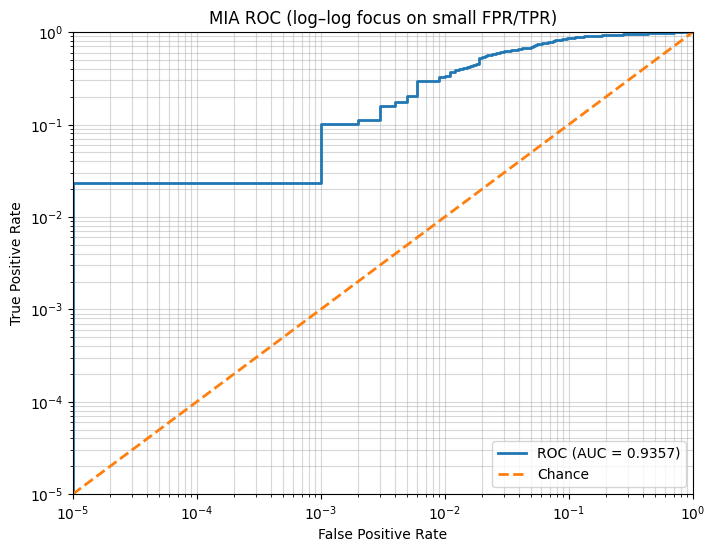

In [32]:
import numpy as np
import matplotlib.pyplot as plt

eps = 1e-12                   
fpr_ = np.clip(fpr, 1e-5, 1) 
tpr_ = np.clip(tpr, 1e-5, 1)

fig, ax = plt.subplots(figsize=(8, 6))

ax.plot(fpr_, tpr_, lw=2, label=f'ROC (AUC = {auc_val:.4f})')
ax.plot([1e-5, 1], [1e-5, 1], lw=2, ls='--', label='Chance')

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim(1e-5, 1.0)
ax.set_ylim(1e-5, 1.0)

ticks = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1]
ax.set_xticks(ticks)
ax.set_yticks(ticks)
ax.get_xaxis().set_minor_formatter(plt.NullFormatter())
ax.get_yaxis().set_minor_formatter(plt.NullFormatter())

ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('MIA ROC (log–log focus on small FPR/TPR)')
ax.legend(loc='lower right')
ax.grid(True, which='both', alpha=0.5)

plt.show()

275.01015615082196


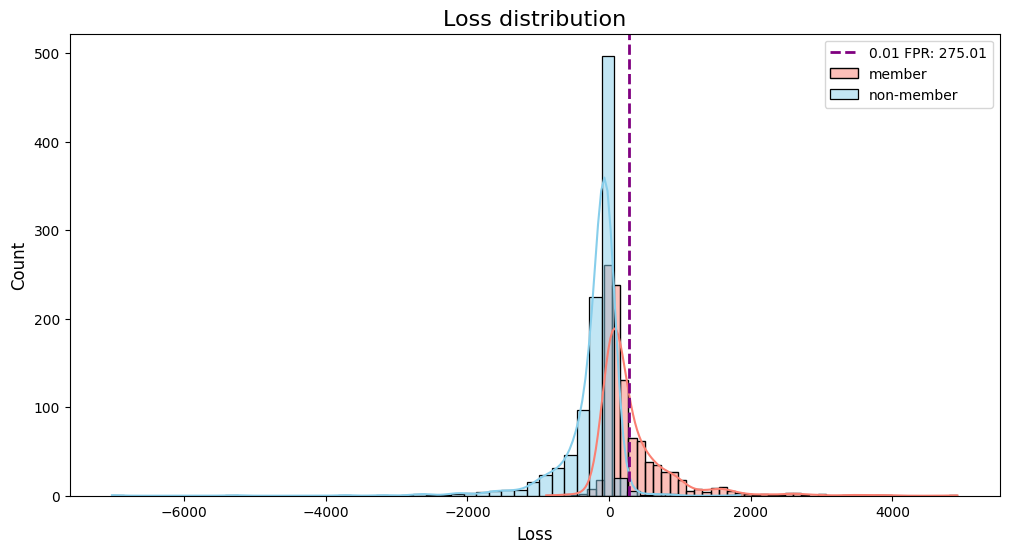

In [33]:
# draw distribution
import matplotlib.pyplot as plt
import seaborn as sns

# y_true = np.array(label_items)
# scores = np.array(scores_test)

scores_mem = scores[y_true == 1]
scores_non = scores[y_true == 0]

plt.figure(figsize=(12, 6))
sns.histplot(scores_mem, bins=50, color='salmon', kde=True, label='member')
sns.histplot(scores_non, bins=50, color='skyblue', kde=True, label='non-member')

threshold_value = np.percentile(scores_non, q=99)
print(threshold_value)
plt.axvline(
    x=threshold_value,
    color='purple',
    linestyle='--',
    linewidth=2,
    label=f'0.01 FPR: {threshold_value:.2f}'
)


plt.title('Loss distribution', fontsize=16)
plt.xlabel('Loss', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.legend(fontsize=10)

plt.show()

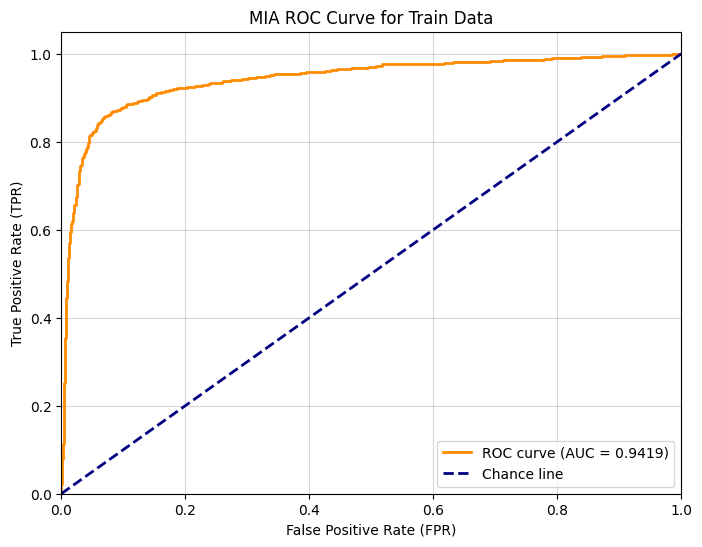

In [25]:
# draw ROC curve and attach the figure in the report
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {auc_val:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Chance line')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title(f'MIA ROC Curve for Train Data')
plt.legend(loc="lower right")
plt.grid(alpha=0.5)
plt.show()